In [1]:
import IPython.display
IPython.display.HTML("<style>.container { width:100% !important; margin: 0 auto; }</style>")

In [2]:
%load_ext autoreload
%autoreload 2

In [126]:
import annoy
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
from boiler.vqvae import VQVAE2
from boiler.mel import Audio2Mel
from boiler.dataset import WavFile
from boiler.train_vqvae import make_dataloader

In [5]:
!ls -lahctr exp/g | tail -3

-rw-rw-r-- 1 proger proger 288M Nov 20 22:45 events.out.tfevents.1605899109.rt.2590117.0
drwxrwxr-x 2 proger proger  303 Nov 20 22:45 .
-rw-rw-r-- 1 proger proger 6.7M Nov 20 22:45 vqvae_300.pt


In [6]:
model = VQVAE2().to('cuda')
model.load_state_dict(torch.load('exp/g/vqvae_300.pt'))

<All keys matched successfully>

In [7]:
#fft = Audio2Mel(n_mel_channels=80, sampling_rate=22050, hop_length=256).cuda()
fft = Audio2Mel(n_mel_channels=80).cuda()

ideas:
1. tf-idf
2. ngrams
3. some kind of temporal pooling?

In [66]:
wav_dir = Path('/home/proger/coub-crawler/monthlyLog/wav/')
wavi = [WavFile(wav) for wav in wav_dir.glob('*.wav')]
wavk = {wavf.filename.stem: i for i, wavf in enumerate(wavi)}

In [127]:
batch_size = 16
loader = make_dataloader(wav_dir, batch_size=batch_size)

bags = []
for batch_number, batch in enumerate(tqdm(loader)):
    bag, _ = model.encode_bag_t(fft(batch.cuda()).unsqueeze(1), normalize=False)
    bags.append(bag)
    #for i, vec in enumerate(bag.split(1), start=batch_size*batch_number):
        #wavi[i] = k
   
bags = torch.cat(bags).cpu()
bags = TfidfTransformer().fit_transform(bags).todense()

100%|██████████| 584/584 [00:06<00:00, 86.14it/s]


In [192]:
batch_size = 1
loader = make_dataloader(wav_dir, batch_size=batch_size)

bags = []
for batch_number, batch in enumerate(tqdm(loader)):
    zs = model.encode(fft(batch.cuda()).unsqueeze(1))
    quant_t = zs[0]

    #quant_t = F.avg_pool2d(quant_t, kernel_size=(3,1)).mean(dim=-1).view(batch_size,-1).detach().cpu()
    quant_t = F.avg_pool2d(quant_t, kernel_size=(3,6)).view(batch_size,-1).detach().cpu()
    # quant_t.view(16,64,-1).mean(dim=-1).detach().cpu()
    bags.append(quant_t)
    del zs
    torch.cuda.empty_cache()

bags = torch.cat(bags).cpu()

100%|██████████| 9344/9344 [00:57<00:00, 161.67it/s]


In [160]:
#F.avg_pool2d(model.encode(fft(batch.cuda()).unsqueeze(1))[1], kernel_size=(6,12)).view(batch_size,-1).detach().cpu().shape

In [194]:
bags[0].shape

torch.Size([960])

In [193]:
index = annoy.AnnoyIndex(960, 'euclidean')

for i, vec in enumerate(bags):
    #index.add_item(i, torch.tensor(vec).view(-1))
    index.add_item(i, vec)

index.build(100)

True

In [196]:
torch.dist(torch.tensor(index.get_item_vector(4194)), vec)

tensor(3.0733)

In [181]:
index.get_nns_by_item(4194, 10, include_distances=Trues)

([4194, 5259, 526, 7750, 8647, 4319, 1111, 4712, 3161, 4403],
 [0.0,
  1.0642412900924683,
  1.166116714477539,
  1.3432937860488892,
  1.349095106124878,
  1.3524765968322754,
  1.4371882677078247,
  1.5221387147903442,
  1.546518325805664,
  1.5466736555099487])

In [197]:
wavk['1lpjeo']

4914

query 299i8h


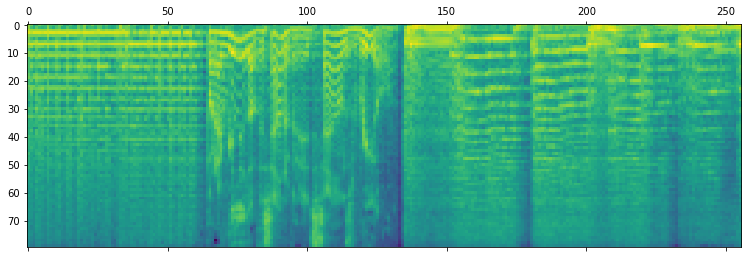

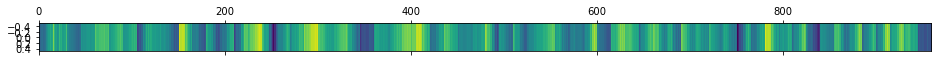

# result 7725 299i8h 0.0


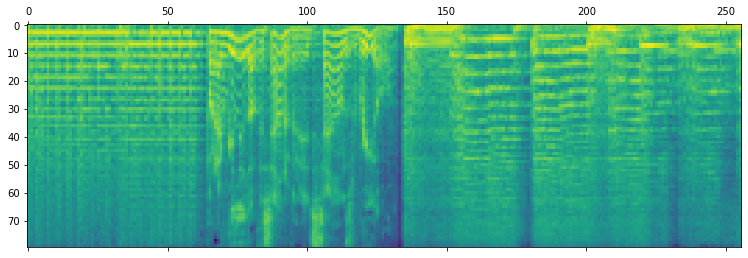

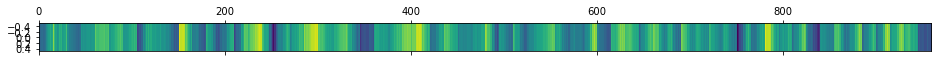

# result 6764 wsqnn 0.9134935140609741


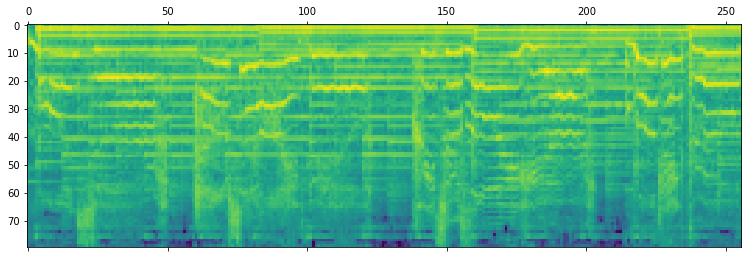

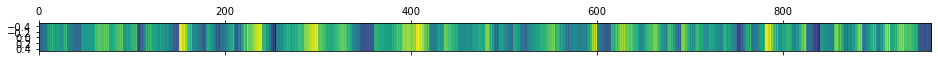

# result 7475 1o3v2j 0.9432992339134216


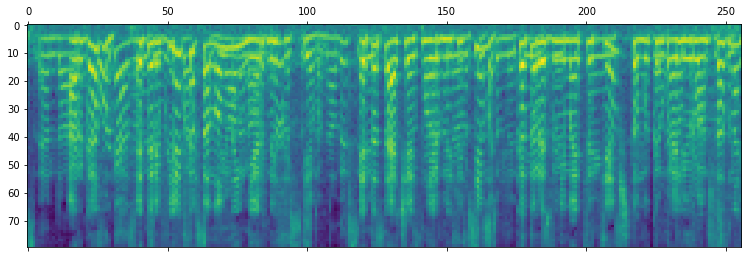

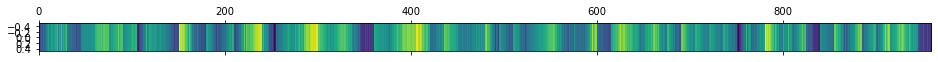

# result 2696 fp9k4 0.9699649214744568


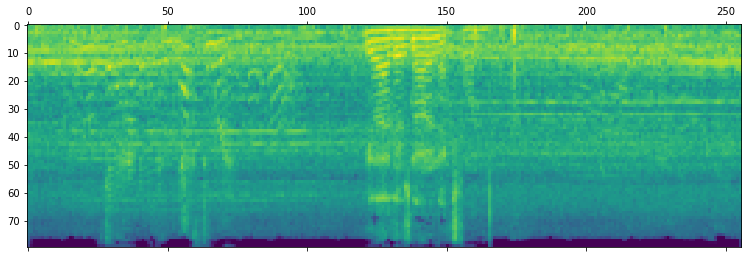

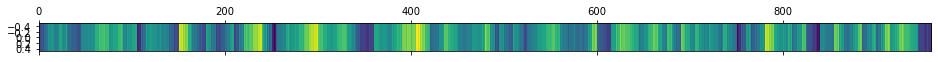

# result 7707 15t0mk 1.0164884328842163


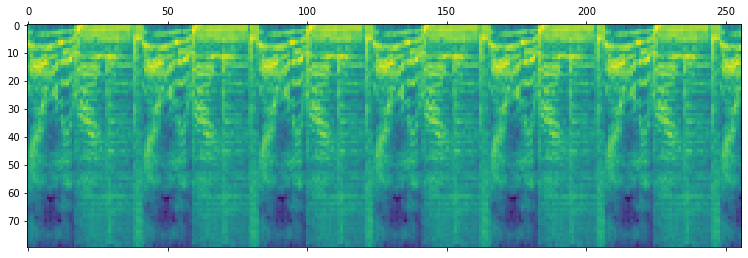

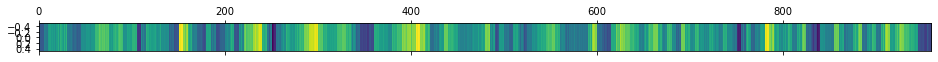

# result 5370 1k7371 1.0273618698120117


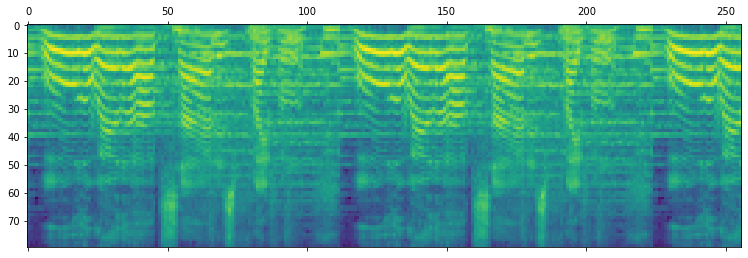

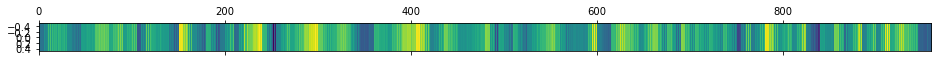

# result 224 17q48s 1.0309734344482422


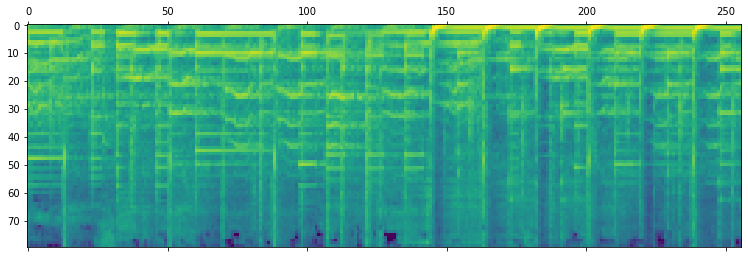

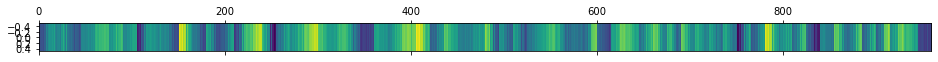

# result 3022 1iwkwd 1.0364925861358643


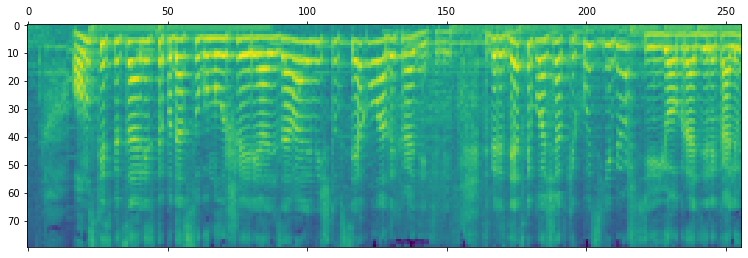

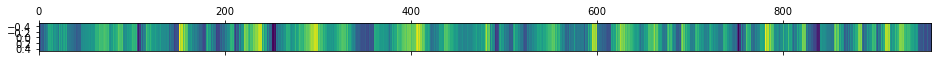

# result 4870 vjgm4 1.0376965999603271


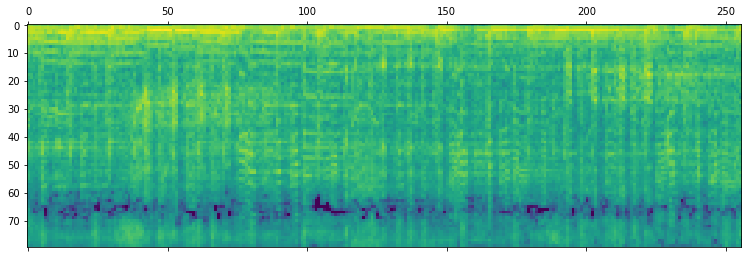

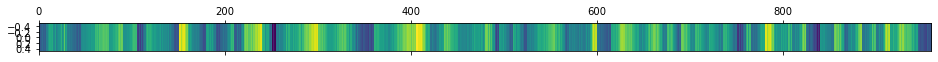

# result 3122 18q547 1.0399527549743652


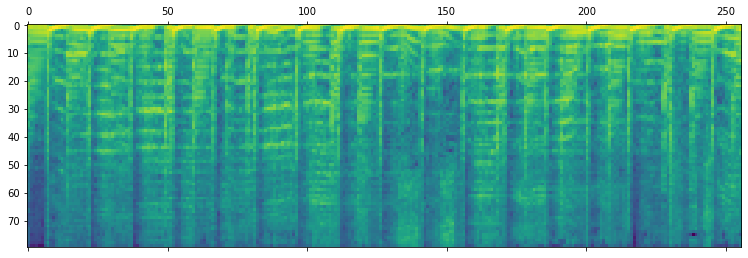

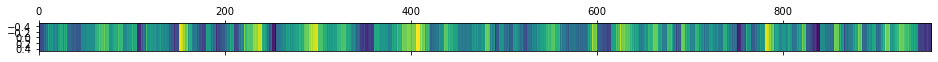

In [212]:
#q = wavi[wavk['1i1eha']] # multi-part
#q = wavi[wavk['1jl4ir']] # rock? 2h37w1
#q_item = wavk['1k7a3p']; q = wavi[q_item] # speech and beats? 207os8
#q_item = wavk['8spya']; q = wavi[q_item] # get low and piano
#q_item = wavk['gk98v']; q = wavi[q_item] # sweet dreams
#q_item = wavk['1mq316']; q = wavi[q_item] # yelling
#q_item = wavk['1ofj8d']; q = wavi[q_item] # news speech 2 langs
q_item = wavk['299i8h']; q = wavi[q_item] # noise electro?
#q = wavi[wavk['1lfp9c']] # rammstein-like?
#q_item = wavk['1lpjeo']; q = wavi[q_item]  # electro? bad
#q_item = wavk['2b5fyy']; q = wavi[q_item] # intertellar

query_audio = q[0]
query_key = q.filename.stem
query = fft(query_audio.unsqueeze(0).cuda())

#vec, ids = model.encode_bag_t(query.unsqueeze(0))
#vec = vec.squeeze()

zs = model.encode(query.unsqueeze(1))
quant_t = zs[0]
#quant_t = F.avg_pool2d(quant_t, kernel_size=(3,1)).mean(dim=-1).view(1,-1).detach().cpu()
quant_t = F.avg_pool2d(quant_t, kernel_size=(3,6)).view(1,-1).detach().cpu()

vec = quant_t.squeeze(0)
ids = zs[3]

print('query', query_key)
#plt.matshow(ids.detach().cpu().squeeze())
#plt.colorbar()

plt.matshow(query.detach().cpu().squeeze())
plt.show()
plt.matshow(vec.detach().cpu()[None,:], aspect=30)
plt.show()
IPython.display.display(IPython.display.Audio(query_audio, rate=16000))

#for i, dist in zip(*index.get_nns_by_vector(vec, 10, include_distances=True)):
for i, dist in zip(*index.get_nns_by_item(q_item, 10, include_distances=True)):
    print('# result', i, wavi[i].filename.stem, dist)
    audio = wavi[i][0]
    feat = fft(audio.unsqueeze(0).cuda())
    plt.matshow(feat.detach().cpu().squeeze())
    plt.show()

    #zs = model.encode(feat.unsqueeze(1))
    #plt.matshow(zs[3].detach().cpu().squeeze())
    #del zs
    
    #plt.show()
    plt.matshow(torch.tensor(index.get_item_vector(i))[None,:], aspect=30)
    plt.show()
    IPython.display.display(IPython.display.Audio(audio, rate=16000))